In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [52]:
df = pd.read_csv('C:/Users/cedua/CDIA - PUCSP/PROJETO 5º SEMESTRE (SAVINO)/WeatherPrediction/data/openw_irradiation_2005_2020.csv')
df.drop(['day', 'weather_id'], axis = 1, inplace=True)

display(df.head())
display(df.tail())

,year,month,temp ºC,feels_like ºC,pressure,humidity %,clouds %,visibility,wind_speed m/s,irrad kwh/m2
0,2005,1,21.041290,21.445806,1015.193548,86.161290,71.290323,7741.935484,3.296774,135.96
1,2005,2,20.410000,20.680000,1016.750000,83.250000,46.428571,8714.285714,3.589286,162.91
2,2005,3,20.905806,21.217097,1018.161290,82.935484,54.354839,8129.032258,3.403226,138.82
3,2005,4,20.427667,20.655000,1020.000000,81.533333,56.166667,8017.241379,3.131667,133.84
4,2005,5,18.132258,18.061290,1020.709677,78.903226,45.000000,7933.333333,2.178065,117.79


,year,month,temp ºC,feels_like ºC,pressure,humidity %,clouds %,visibility,wind_speed m/s,irrad kwh/m2
187,2020,8,16.638065,16.261935,1020.225806,75.419355,33.870968,9193.548387,3.257742,133.68
188,2020,9,20.469333,20.342333,1019.166667,68.500000,46.000000,8300.000000,3.676333,151.77
189,2020,10,19.894839,19.894839,1014.096774,76.483871,54.838710,8919.354839,3.698710,165.86
190,2020,11,19.398000,19.384000,1017.633333,75.433333,51.000000,9133.333333,4.270667,185.15
191,2020,12,21.540000,21.842581,1016.193548,79.064516,51.451613,9096.774194,3.503226,166.73


In [53]:
#features and target
X = df.drop(['irrad kwh/m2'], axis=1)
y = df[['irrad kwh/m2']]

In [54]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [55]:
#default parameters
xgb.XGBRegressor().get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [56]:
xg_reg = xgb.XGBRegressor()
# training the model
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [57]:
# predicting
xgb_preds = xg_reg.predict(X_test)
xgb_preds

array([118.130264, 114.73563 , 101.42404 , 176.47775 , 112.80841 ,
       157.99327 , 110.982155, 108.196976, 110.56889 , 137.60085 ,
       110.87699 , 109.21667 , 102.76564 , 104.48606 , 167.93588 ,
       109.639755, 188.73145 , 113.77642 , 139.08853 , 114.32364 ,
       150.87944 , 150.07391 , 167.99814 , 133.70808 , 118.03198 ,
       133.8792  , 142.81291 , 151.81943 , 145.09813 , 150.08461 ,
       108.7888  , 154.68489 , 131.83202 , 119.56206 , 156.33952 ,
       113.300896, 167.98074 , 153.09451 , 132.89561 , 149.40417 ,
       212.66118 , 115.48822 , 165.70786 , 158.96251 , 104.79509 ,
       167.0878  ,  96.5487  , 133.39662 ], dtype=float32)

In [58]:
print('R score is :', r2_score(y_test, xgb_preds))

R score is : 0.7161429386819012


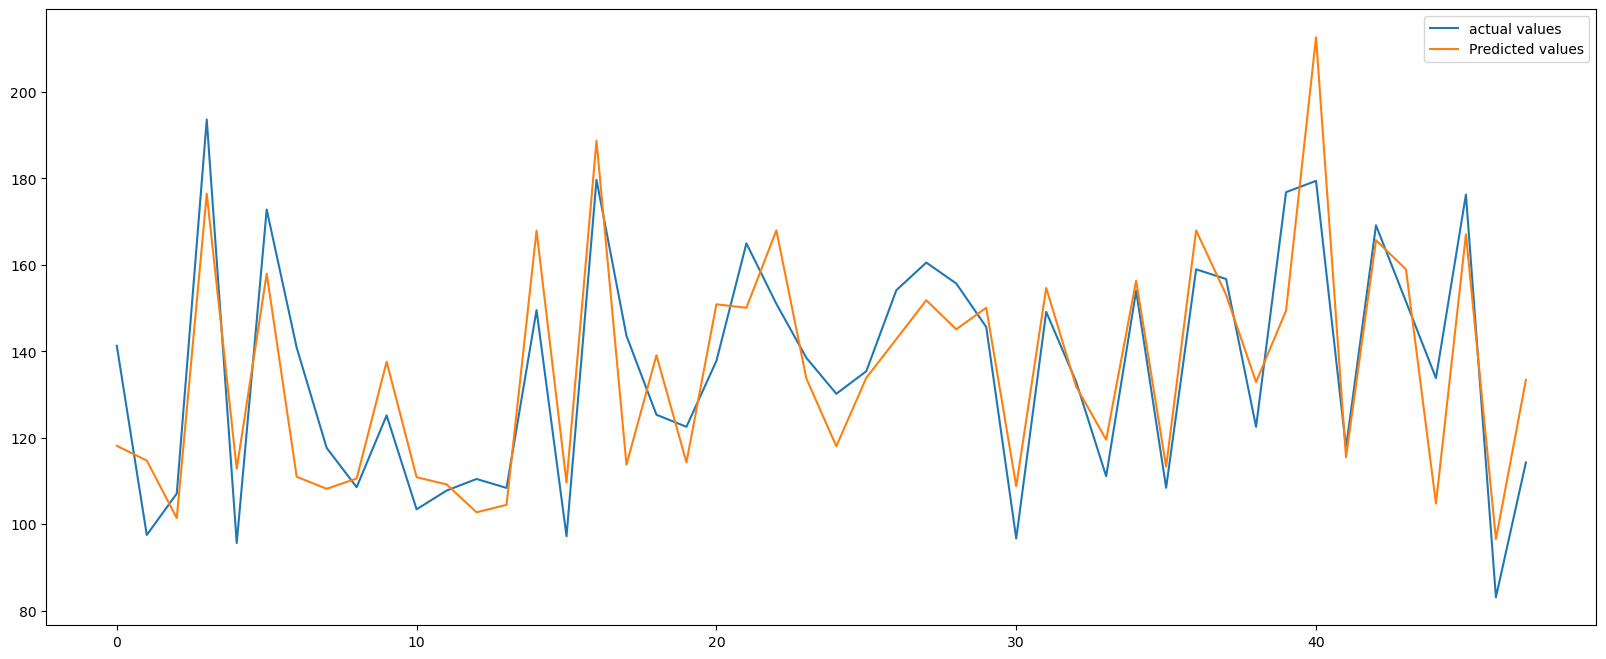

In [59]:
plt.figure(figsize=(20, 8))
# plotting the graphs
plt.plot([i for i in range(len(y_test))],y_test, label="actual values")
plt.plot([i for i in range(len(y_test))],xgb_preds, label="Predicted values")
# plt.axis('off')
# showing the plotting
plt.legend()
plt.show()

In [60]:
print(f'A predição foi de {len(xgb_preds)} meses, ou seja, {int(len(xgb_preds)/12)} anos')

A predição foi de 48 meses, ou seja, 4 anos


##### Trying to increase R score --> *Normalization*

In [61]:
scaler = StandardScaler()

In [62]:
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-1.62697843, -1.59325501,  0.82894386, ...,  1.88588101,
        -1.16296189,  0.1714547 ],
       [-1.62697843, -1.30357228,  0.55599103, ..., -0.01632264,
        -0.10707149,  0.62958869],
       [-1.62697843, -1.01388955,  0.77036431, ...,  0.59012598,
        -0.74260742,  0.33818011],
       ...,
       [ 1.62697843,  1.01388955,  0.33324925, ...,  0.62714755,
         0.11561629,  0.80096941],
       [ 1.62697843,  1.30357228,  0.11842965, ...,  0.33344307,
         0.3479789 ,  1.69677323],
       [ 1.62697843,  1.59325501,  1.04457241, ...,  0.36799654,
         0.30827876,  0.49480094]])

In [63]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_scaled, y, test_size = 0.25, random_state = 42)

In [64]:
xg_reg_norm = xgb.XGBRegressor()

xg_reg_norm.fit(X_train_norm ,y_train_norm)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [65]:
xgb_preds_norm = xg_reg_norm.predict(X_test_norm)
xgb_preds_norm

array([118.130264, 114.73563 , 101.42404 , 176.47775 , 112.80841 ,
       157.99327 , 110.982155, 108.191444, 110.56889 , 137.6033  ,
       110.87699 , 109.21667 , 102.76012 , 104.48606 , 167.93588 ,
       109.639755, 188.73145 , 113.77642 , 139.08853 , 114.32364 ,
       150.87944 , 150.07391 , 167.99728 , 133.70808 , 118.03198 ,
       133.81474 , 142.81291 , 151.81943 , 145.09813 , 150.08461 ,
       109.04048 , 154.68489 , 131.83202 , 119.56206 , 156.33952 ,
       113.300896, 167.98074 , 153.09451 , 132.89561 , 149.40417 ,
       212.66032 , 115.48269 , 165.70786 , 158.96251 , 104.79509 ,
       167.0878  ,  96.5487  , 133.39662 ], dtype=float32)

In [66]:
print('R score is :', r2_score(y_test_norm, xgb_preds_norm))

R score is : 0.7159522222534516


### Próximos passos:
- GridSearchCV para melhorar o modelo?

### Dúvida:
- Tem como estabelecer uma quantidade de previsões? 